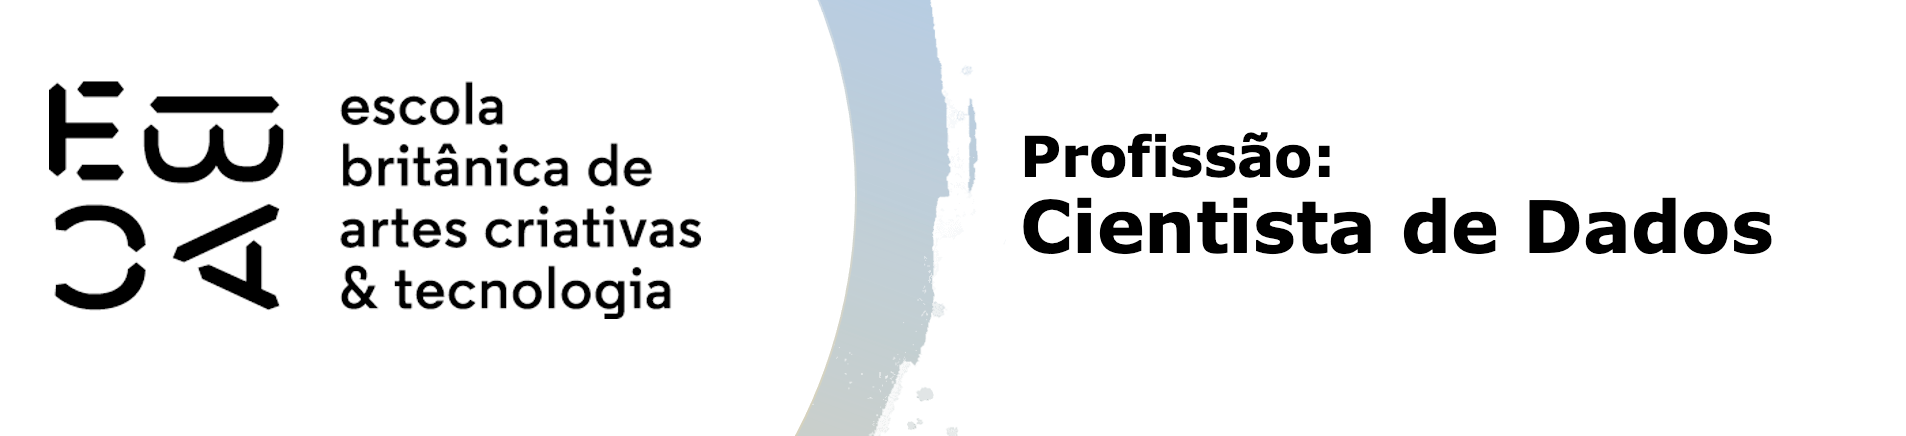

# Projeto Credit Score - Marcos Rocha

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [16]:
from pycaret.classification import *

In [17]:

from pycaret.classification import*
import pandas as pd
df = pd.read_csv('credit_scoring.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [18]:
# ============================================================
# ETAPA: AMOSTRAGEM - Separação Out Of Time (OOT)
# ============================================================

# Convertendo a variável data_ref para formato datetime
# Isso é necessário para garantir ordenação correta das safras
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Ordenando a base por data_ref
# Garantimos que estamos identificando corretamente as últimas safras
df = df.sort_values('data_ref')

# Identificando as safras existentes
safras = df['data_ref'].sort_values().unique()

print("Total de safras na base:", len(safras))
print("Safras disponíveis:")
print(safras)

# Selecionando as 3 últimas safras como validação Out Of Time (OOT)
safras_oot = safras[-3:]

print("\nSafras selecionadas para OOT:")
print(safras_oot)

# Separando base de desenvolvimento (treino)
df_dev = df[~df['data_ref'].isin(safras_oot)].copy()

# Separando base Out Of Time (validação temporal)
df_oot = df[df['data_ref'].isin(safras_oot)].copy()

print("\nDimensão base desenvolvimento:", df_dev.shape)
print("Dimensão base OOT:", df_oot.shape)

Total de safras na base: 15
Safras disponíveis:
<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

Safras selecionadas para OOT:
<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

Dimensão base desenvolvimento: (600000, 15)
Dimensão base OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [19]:
# ============================================================
# ETAPA: DESCRITIVA BÁSICA - VISÃO GERAL DA BASE
# ============================================================

# Número total de linhas e colunas
print("Dimensão da base (linhas, colunas):", df.shape)

# Número total de registros
print("Número total de registros:", df.shape[0])

# Número total de variáveis
print("Número total de variáveis:", df.shape[1])

Dimensão da base (linhas, colunas): (750000, 15)
Número total de registros: 750000
Número total de variáveis: 15


In [20]:
# ============================================================
# ETAPA: DISTRIBUIÇÃO TEMPORAL (SAFRAS)
# ============================================================

# Garantindo que data_ref está no formato datetime
df['data_ref'] = pd.to_datetime(df['data_ref'])

# Contagem de registros por mês (safra)
volume_por_safra = df.groupby('data_ref').size().sort_index()

print("Volume de registros por safra:")
print(volume_por_safra)

# Percentual por safra (opcional)
print("\nPercentual por safra:")
print((volume_por_safra / df.shape[0]) * 100)

Volume de registros por safra:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
dtype: int64

Percentual por safra:
data_ref
2015-01-01    6.666667
2015-02-01    6.666667
2015-03-01    6.666667
2015-04-01    6.666667
2015-05-01    6.666667
2015-06-01    6.666667
2015-07-01    6.666667
2015-08-01    6.666667
2015-09-01    6.666667
2015-10-01    6.666667
2015-11-01    6.666667
2015-12-01    6.666667
2016-01-01    6.666667
2016-02-01    6.666667
2016-03-01    6.666667
dtype: float64


In [21]:
# ============================================================
# ETAPA: IDENTIFICAÇÃO DO TIPO DAS VARIÁVEIS
# ============================================================

# Variáveis quantitativas
variaveis_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Variáveis qualitativas (categóricas)
variaveis_qualitativas = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Variáveis quantitativas:")
print(variaveis_quantitativas)

print("\nVariáveis qualitativas:")
print(variaveis_qualitativas)

Variáveis quantitativas:
['index', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

Variáveis qualitativas:
['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']


In [22]:
# ============================================================
# ETAPA: DESCRITIVA UNIVARIADA - VARIÁVEIS QUANTITATIVAS
# ============================================================

# Estatísticas principais
descricao_quant = df[variaveis_quantitativas].describe()

print("Estatísticas descritivas das variáveis quantitativas:")
print(descricao_quant)

# Verificando valores ausentes
print("\nQuantidade de valores ausentes por variável quantitativa:")
print(df[variaveis_quantitativas].isnull().sum())

Estatísticas descritivas das variáveis quantitativas:
               index     qtd_filhos          idade  tempo_emprego  \
count  750000.000000  750000.000000  750000.000000  624043.000000   
mean     8319.272793       0.433251      43.804733       7.748574   
std      4809.281774       0.739379      11.229868       6.687455   
min         0.000000       0.000000      22.000000       0.117808   
25%      4147.000000       0.000000      34.000000       3.049315   
50%      8324.000000       0.000000      43.000000       6.046575   
75%     12487.000000       1.000000      53.000000      10.183562   
max     16649.000000      14.000000      68.000000      42.906849   

       qt_pessoas_residencia         renda  
count          750000.000000  7.500000e+05  
mean                2.212241  2.323854e+04  
std                 0.903428  7.910601e+04  
min                 1.000000  1.076700e+02  
25%                 2.000000  3.467700e+03  
50%                 2.000000  7.861820e+03  
75%      

In [23]:
# ============================================================
# ETAPA: DESCRITIVA UNIVARIADA - VARIÁVEIS QUALITATIVAS
# ============================================================

for col in variaveis_qualitativas:
    
    print("\n" + "="*50)
    print(f"Variável: {col}")
    
    # Contagem absoluta
    contagem = df[col].value_counts(dropna=False)
    print("\nFrequência absoluta:")
    print(contagem)
    
    # Frequência relativa
    print("\nFrequência relativa (%):")
    print((contagem / df.shape[0]) * 100)
    
    # Valores ausentes
    print("\nValores ausentes:")
    print(df[col].isnull().sum())


Variável: sexo

Frequência absoluta:
sexo
F    504580
M    245420
Name: count, dtype: int64

Frequência relativa (%):
sexo
F    67.277333
M    32.722667
Name: count, dtype: float64

Valores ausentes:
0

Variável: posse_de_veiculo

Frequência absoluta:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Frequência relativa (%):
posse_de_veiculo
N    61.060533
S    38.939467
Name: count, dtype: float64

Valores ausentes:
0

Variável: posse_de_imovel

Frequência absoluta:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Frequência relativa (%):
posse_de_imovel
S    67.158933
N    32.841067
Name: count, dtype: float64

Valores ausentes:
0

Variável: tipo_renda

Frequência absoluta:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Frequência relativa (%):
tipo_renda
Assalariado         51.432000
Empresário          23.028267
Pensionis

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [24]:
# ============================================================
# ETAPA: DEFINIÇÃO DAS VARIÁVEIS PARA ANÁLISE BIVARIADA
# ============================================================

# Removendo variáveis que não entram na modelagem
variaveis_explicativas = df.drop(columns=['data_ref', 'index', 'mau']).columns

# Separando por tipo
variaveis_quantitativas = df[variaveis_explicativas].select_dtypes(include=['int64', 'float64']).columns
variaveis_qualitativas = df[variaveis_explicativas].select_dtypes(include=['object', 'category', 'bool']).columns

print("Quantitativas:", variaveis_quantitativas.tolist())
print("Qualitativas:", variaveis_qualitativas.tolist())

Quantitativas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Qualitativas: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']


In [25]:
# ============================================================
# ANÁLISE BIVARIADA - VARIÁVEIS QUANTITATIVAS
# ============================================================

for col in variaveis_quantitativas:
    
    print("\n" + "="*60)
    print(f"Variável: {col}")
    
    # Estatísticas por target
    resumo = df.groupby('mau')[col].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    print("\nEstatísticas por target:")
    print(resumo)
    
    # Correlação com o target
    correlacao = df[[col, 'mau']].corr().iloc[0,1]
    print(f"\nCorrelação com target (mau): {correlacao:.4f}")
    
    # Taxa de inadimplência por faixas (binning simples)
    df['faixa_temp'] = pd.qcut(df[col], q=5, duplicates='drop')
    
    taxa_por_faixa = df.groupby('faixa_temp')['mau'].mean()
    
    print("\nTaxa de inadimplência por faixa (quintis):")
    print(taxa_por_faixa)
    
    # Removendo coluna temporária
    df.drop(columns=['faixa_temp'], inplace=True)


Variável: qtd_filhos

Estatísticas por target:
        count      mean  median       std  min  max
mau                                                
False  691357  0.431739     0.0  0.737456    0   14
True    58643  0.451068     0.0  0.761465    0   14

Correlação com target (mau): 0.0070

Taxa de inadimplência por faixa (quintis):
faixa_temp
(-0.001, 1.0]    0.078055
(1.0, 14.0]      0.079337
Name: mau, dtype: float64

Variável: idade

Estatísticas por target:
        count       mean  median        std  min  max
mau                                                  
False  691357  43.896274    43.0  11.193997   22   68
True    58643  42.725543    41.0  11.590152   22   68

Correlação com target (mau): -0.0280

Taxa de inadimplência por faixa (quintis):
faixa_temp
(21.999, 33.0]    0.094129
(33.0, 40.0]      0.080035
(40.0, 47.0]      0.072404
(47.0, 55.0]      0.065459
(55.0, 68.0]      0.075494
Name: mau, dtype: float64

Variável: tempo_emprego

Estatísticas por target:
        co

In [26]:
print("Taxa geral de inadimplência:", df['mau'].mean())

Taxa geral de inadimplência: 0.07819066666666667


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [27]:
# ============================================================
# MODELO COM TRATAMENTO DE MISSING VALUES
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Separando variáveis
X_dev = df_dev.drop(columns=['data_ref', 'index', 'mau'])
y_dev = df_dev['mau']

X_oot = df_oot.drop(columns=['data_ref', 'index', 'mau'])
y_oot = df_oot['mau']

# Identificando tipos
num_cols = X_dev.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_dev.select_dtypes(include=['object', 'category', 'bool']).columns

# Pipeline para numéricas (imputação com mediana)
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline para categóricas (imputação + one hot)
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Pré-processamento completo
preprocessador = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ]
)

# Pipeline final
modelo = Pipeline(steps=[
    ('preprocessamento', preprocessador),
    ('logistica', LogisticRegression(max_iter=1000))
])

# Treinando
modelo.fit(X_dev, y_dev)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object'))])),
                ('logistica', LogisticRegression(max_iter=1000))])

In [28]:
from sklearn.metrics import roc_curve

def calcular_ks(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return max(tpr - fpr)

In [29]:
# Probabilidades
prob_dev = modelo.predict_proba(X_dev)[:,1]
pred_dev = modelo.predict(X_dev)

acuracia_dev = accuracy_score(y_dev, pred_dev)
auc_dev = roc_auc_score(y_dev, prob_dev)
gini_dev = 2 * auc_dev - 1
ks_dev = calcular_ks(y_dev, prob_dev)

print("===== DESENVOLVIMENTO =====")
print("Acurácia:", round(acuracia_dev,4))
print("AUC:", round(auc_dev,4))
print("Gini:", round(gini_dev,4))
print("KS:", round(ks_dev,4))

===== DESENVOLVIMENTO =====
Acurácia: 0.9389
AUC: 0.7648
Gini: 0.5296
KS: 0.3932


In [30]:
prob_oot = modelo.predict_proba(X_oot)[:,1]
pred_oot = modelo.predict(X_oot)

acuracia_oot = accuracy_score(y_oot, pred_oot)
auc_oot = roc_auc_score(y_oot, prob_oot)
gini_oot = 2 * auc_oot - 1
ks_oot = calcular_ks(y_oot, prob_oot)

print("===== OUT OF TIME =====")
print("Acurácia:", round(acuracia_oot,4))
print("AUC:", round(auc_oot,4))
print("Gini:", round(gini_oot,4))
print("KS:", round(ks_oot,4))

===== OUT OF TIME =====
Acurácia: 0.8533
AUC: 0.7208
Gini: 0.4417
KS: 0.3234


Algumas categorias apresentaram p-value superior a 5%, indicando ausência de significância estatística individual. Isso significa que, dado o conjunto de variáveis do modelo, essas categorias não apresentam efeito estatisticamente diferente da categoria de referência na explicação da inadimplência.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [31]:
# ============================================================
# VERIFICAÇÃO DE VALORES NULOS
# ============================================================

# Quantidade total de nulos por variável
nulos_por_variavel = df.isnull().sum()

# Filtrando apenas variáveis com nulos
nulos_por_variavel = nulos_por_variavel[nulos_por_variavel > 0]

print("Variáveis com valores nulos:")
print(nulos_por_variavel)

# Percentual de nulos
print("\nPercentual de nulos:")
print((nulos_por_variavel / df.shape[0]) * 100)

Variáveis com valores nulos:
tempo_emprego    125957
dtype: int64

Percentual de nulos:
tempo_emprego    16.794267
dtype: float64


In [32]:
# Separando tipos
variaveis_numericas = df.select_dtypes(include=['int64', 'float64']).columns
variaveis_categoricas = df.select_dtypes(include=['object', 'category', 'bool']).columns

print("\nNulos em variáveis numéricas:")
print(df[variaveis_numericas].isnull().sum()[df[variaveis_numericas].isnull().sum() > 0])

print("\nNulos em variáveis categóricas:")
print(df[variaveis_categoricas].isnull().sum()[df[variaveis_categoricas].isnull().sum() > 0])


Nulos em variáveis numéricas:
tempo_emprego    125957
dtype: int64

Nulos em variáveis categóricas:
Series([], dtype: int64)


In [33]:
SimpleImputer(strategy='median')

SimpleImputer(strategy='median')

In [34]:
# Criando flag de missing
df['tempo_emprego_missing'] = df['tempo_emprego'].isnull().astype(int)

# Taxa de inadimplência
print(df.groupby('tempo_emprego_missing')['mau'].mean())

tempo_emprego_missing
0    0.077298
1    0.082615
Name: mau, dtype: float64


In [35]:
# ============================================================
# TRATAMENTO DE MISSING - IMPUTAÇÃO PELA MEDIANA
# ============================================================

# Calculando mediana na base de desenvolvimento
mediana_tempo_emprego = df_dev['tempo_emprego'].median()

print("Mediana de tempo_emprego:", mediana_tempo_emprego)

# Aplicando imputação
df_dev['tempo_emprego'] = df_dev['tempo_emprego'].fillna(mediana_tempo_emprego)

# Aplicando mesma mediana na base OOT (evita data leakage)
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(mediana_tempo_emprego)

# Conferindo se ainda existem nulos
print("Nulos após imputação (Dev):", df_dev['tempo_emprego'].isnull().sum())
print("Nulos após imputação (OOT):", df_oot['tempo_emprego'].isnull().sum())

Mediana de tempo_emprego: 6.046575342465753
Nulos após imputação (Dev): 0
Nulos após imputação (OOT): 0


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [36]:
# ============================================================
# TRATAMENTO DE OUTLIERS - WINSORIZAÇÃO
# ============================================================

# Selecionando variáveis numéricas (somente explicativas)
# Removemos data_ref, index e mau porque não são covariáveis
variaveis_numericas = df_dev.drop(columns=['data_ref', 'index', 'mau']) \
                            .select_dtypes(include=['int64', 'float64']) \
                            .columns


# Percorrendo cada variável numérica para aplicar tratamento
for col in variaveis_numericas:
    
    # --------------------------------------------------------
    # Calculando os percentis 1% e 99% na base de desenvolvimento
    # Isso evita vazamento de informação para a base OOT
    # --------------------------------------------------------
    p1 = df_dev[col].quantile(0.01)
    p99 = df_dev[col].quantile(0.99)
    
    print(f"\nTratando variável: {col}")
    print(f"Limite inferior (P1): {p1}")
    print(f"Limite superior (P99): {p99}")
    
    # --------------------------------------------------------
    # Aplicando winsorização na base de desenvolvimento
    # Valores abaixo de P1 recebem P1
    # Valores acima de P99 recebem P99
    # --------------------------------------------------------
    df_dev[col] = df_dev[col].clip(lower=p1, upper=p99)
    
    # --------------------------------------------------------
    # Aplicando os mesmos limites na base Out Of Time
    # Mantendo consistência e evitando recalcular limites
    # --------------------------------------------------------
    df_oot[col] = df_oot[col].clip(lower=p1, upper=p99)

print("\nTratamento de outliers concluído.")


Tratando variável: qtd_filhos
Limite inferior (P1): 0.0
Limite superior (P99): 3.0

Tratando variável: idade
Limite inferior (P1): 25.0
Limite superior (P99): 66.0

Tratando variável: tempo_emprego
Limite inferior (P1): 0.347945205479452
Limite superior (P99): 30.56712328767124

Tratando variável: qt_pessoas_residencia
Limite inferior (P1): 1.0
Limite superior (P99): 5.0

Tratando variável: renda
Limite inferior (P1): 858.2
Limite superior (P99): 326248.09

Tratamento de outliers concluído.


In [37]:
# ============================================================
# TRANSFORMAÇÃO LOGARÍTMICA DA VARIÁVEL RENDA
# ============================================================

# Aplicando transformação logarítmica na base de desenvolvimento
# np.log1p(x) calcula log(1 + x)
# Utilizamos log1p em vez de log porque ele permite valores iguais a zero
# Essa transformação reduz a assimetria da variável renda,
# comprimindo valores muito altos e aproximando a distribuição de algo mais simétrico,
# o que melhora a estabilidade da regressão logística.

df_dev['renda'] = np.log1p(df_dev['renda'])


# Aplicando a mesma transformação na base Out Of Time (OOT)
# É fundamental aplicar exatamente o mesmo tratamento realizado na base de desenvolvimento,
# garantindo consistência temporal e evitando qualquer tipo de distorção na avaliação do modelo.

df_oot['renda'] = np.log1p(df_oot['renda'])

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

Para a seleção de variáveis, foi utilizada a técnica de Information Value (IV), amplamente empregada em modelos de Credit Scoring.

O Information Value mede o poder preditivo individual de cada variável na distinção entre clientes adimplentes e inadimplentes. Diferentemente de técnicas baseadas apenas em importância do modelo (como feature importance) ou métodos mais complexos como Boruta, o IV é uma métrica interpretável, estável e tradicionalmente utilizada no mercado financeiro.

Essa técnica é especialmente adequada para regressão logística, pois permite avaliar previamente a capacidade discriminante das variáveis antes da modelagem, reduzindo ruído, evitando inclusão de variáveis pouco informativas e contribuindo para maior estabilidade temporal do modelo.

Além disso, o uso do IV está alinhado às práticas regulatórias e à necessidade de interpretabilidade em modelos de crédito, tornando-o mais apropriado do que métodos puramente preditivos ou baseados em algoritmos de árvore.

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [38]:
# ============================================================
# REDUÇÃO DE DIMENSIONALIDADE - PCA
# ============================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Separando variáveis explicativas
X_dev = df_dev.drop(columns=['data_ref', 'index', 'mau'])
X_oot = df_oot.drop(columns=['data_ref', 'index', 'mau'])

# Identificando variáveis numéricas e categóricas
num_cols = X_dev.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_dev.select_dtypes(include=['object', 'category', 'bool']).columns

# Pipeline numérico: imputação + padronização
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline categórico: imputação + one hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Pré-processamento completo
preprocessador = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Criando pipeline com PCA
pipeline_pca = Pipeline([
    ('preprocessamento', preprocessador),
    ('pca', PCA(n_components=5))
])

# Ajustando apenas na base de desenvolvimento
pipeline_pca.fit(X_dev)

# Transformando as bases
X_dev_pca = pipeline_pca.transform(X_dev)
X_oot_pca = pipeline_pca.transform(X_oot)

print("Nova dimensão após PCA (Dev):", X_dev_pca.shape)
print("Nova dimensão após PCA (OOT):", X_oot_pca.shape)

Nova dimensão após PCA (Dev): (600000, 5)
Nova dimensão após PCA (OOT): (150000, 5)


In [39]:
# Extraindo PCA ajustado
pca_model = pipeline_pca.named_steps['pca']

print("Variância explicada por componente:")
print(pca_model.explained_variance_ratio_)

print("\nVariância explicada acumulada:")
print(pca_model.explained_variance_ratio_.cumsum())

Variância explicada por componente:
[0.31923053 0.2345485  0.11824202 0.05686661 0.05002844]

Variância explicada acumulada:
[0.31923053 0.55377903 0.67202105 0.72888766 0.77891609]


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [40]:
# ============================================================
# CRIAÇÃO DE DUMMIES COM PANDAS
# ============================================================

# Lista de variáveis categóricas que devem ser transformadas
variaveis_categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

# Aplicando get_dummies na base de desenvolvimento
# drop_first=True evita multicolinearidade (dummy trap)
df_dev_dummies = pd.get_dummies(
    df_dev,
    columns=variaveis_categoricas,
    drop_first=True
)

# Aplicando o mesmo procedimento na base OOT
df_oot_dummies = pd.get_dummies(
    df_oot,
    columns=variaveis_categoricas,
    drop_first=True
)

print("Dimensão após criação de dummies (Dev):", df_dev_dummies.shape)
print("Dimensão após criação de dummies (OOT):", df_oot_dummies.shape)

Dimensão após criação de dummies (Dev): (600000, 28)
Dimensão após criação de dummies (OOT): (150000, 28)


In [41]:
# Alinhando colunas entre Dev e OOT
df_dev_dummies, df_oot_dummies = df_dev_dummies.align(
    df_oot_dummies,
    join='left',
    axis=1,
    fill_value=0
)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [42]:
# ============================================================
# PIPELINE DE PREPROCESSAMENTO COMPLETO
# ============================================================

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# ------------------------------------------------------------
# 1️⃣ Criando transformador personalizado para winsorização
# ------------------------------------------------------------

class Winsorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
    
    def fit(self, X, y=None):
        # Calculando limites com base na base de desenvolvimento
        self.lower_bounds_ = X.quantile(self.lower_quantile)
        self.upper_bounds_ = X.quantile(self.upper_quantile)
        return self
    
    def transform(self, X):
        # Aplicando truncamento nos limites calculados
        return X.clip(self.lower_bounds_, self.upper_bounds_, axis=1)

# ------------------------------------------------------------
# 2️⃣ Separando colunas
# ------------------------------------------------------------

variaveis_numericas = [
    'qtd_filhos',
    'idade',
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda'
]

variavel_dummy = ['posse_de_veiculo']

# ------------------------------------------------------------
# 3️⃣ Pipeline numérico
# - Imputação
# - Winsorização
# - Padronização
# ------------------------------------------------------------

pipeline_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsor', Winsorizer(0.01, 0.99)),
    ('scaler', StandardScaler())
])

# ------------------------------------------------------------
# 4️⃣ Pipeline categórico (dummy apenas para posse_de_veiculo)
# ------------------------------------------------------------

pipeline_dummy = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ------------------------------------------------------------
# 5️⃣ ColumnTransformer
# ------------------------------------------------------------

preprocessador = ColumnTransformer([
    ('num', pipeline_numerico, variaveis_numericas),
    ('dummy', pipeline_dummy, variavel_dummy)
])

# ------------------------------------------------------------
# 6️⃣ Pipeline final com PCA
# ------------------------------------------------------------

pipeline_final = Pipeline([
    ('preprocessamento', preprocessador),
    ('pca', PCA(n_components=5))
])

print("Pipeline criado com sucesso.")

Pipeline criado com sucesso.


In [43]:
# ============================================================
# WINSORIZER COMPATÍVEL COM SKLEARN 
# ============================================================

class Winsorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
    
    def fit(self, X, y=None):
        # X agora é numpy array
        self.lower_bounds_ = np.quantile(X, self.lower_quantile, axis=0)
        self.upper_bounds_ = np.quantile(X, self.upper_quantile, axis=0)
        return self
    
    def transform(self, X):
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)

In [44]:
pipeline_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('winsor', Winsorizer(0.01, 0.99)),
    ('scaler', StandardScaler())
])

pipeline_dummy = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessador = ColumnTransformer([
    ('num', pipeline_numerico, variaveis_numericas),
    ('dummy', pipeline_dummy, variavel_dummy)
])

pipeline_final = Pipeline([
    ('preprocessamento', preprocessador),
    ('pca', PCA(n_components=5))
])

In [45]:
pipeline_final.fit(df_dev)

X_dev_processado = pipeline_final.transform(df_dev)
X_oot_processado = pipeline_final.transform(df_oot)

print("Pipeline funcionando corretamente.")
print("Nova dimensão:", X_dev_processado.shape)

Pipeline funcionando corretamente.
Nova dimensão: (600000, 5)


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.


In [46]:
# Base de desenvolvimento
base_pycaret = df_dev.copy()

# Removendo variáveis que não entram no modelo
base_pycaret = base_pycaret.drop(columns=['data_ref', 'index'])

In [47]:
clf = setup(
    data=base_pycaret,
    target='mau',
    session_id=42,
    normalize=True,
    remove_outliers=True,
    transformation=True,
    pca=False,
    feature_selection=False
)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 13)"
4,Transformed data shape,"(579001, 30)"
5,Transformed train set shape,"(399001, 30)"
6,Transformed test set shape,"(180000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


O pré-processamento dos dados foi realizado utilizando a biblioteca PyCaret. O processo incluiu imputação de valores ausentes (média para variáveis numéricas e moda para categóricas), codificação One-Hot das variáveis categóricas, normalização dos dados via Z-score e transformação Yeo-Johnson para redução de assimetria. Adicionalmente, foi aplicado tratamento automático de outliers, resultando na remoção de aproximadamente 3,5% das observações. O conjunto final apresentou 30 variáveis após transformação, sendo utilizado esquema de validação cruzada estratificada com 10 folds, preservando a proporção de inadimplentes.

In [48]:
modelo_lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9389,0.7681,0.0000,0.0000,0.0000,-0.0001,-0.0018
1,0.9389,0.7756,0.0008,0.4000,0.0016,0.0013,0.0154
2,0.9389,0.7597,0.0004,0.2500,0.0008,0.0006,0.0077
3,0.9388,0.7733,0.0008,0.2500,0.0016,0.0012,0.0109
4,0.9389,0.7668,0.0000,0.0000,0.0000,-0.0001,-0.0018
5,0.9389,0.7654,0.0016,0.3636,0.0031,0.0026,0.0205
6,0.9388,0.7675,0.0004,0.1429,0.0008,0.0004,0.0044
7,0.9389,0.7655,0.0008,0.4000,0.0016,0.0013,0.0154
8,0.9389,0.7753,0.0004,0.2500,0.0008,0.0006,0.0077


In [49]:
evaluate_model(modelo_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

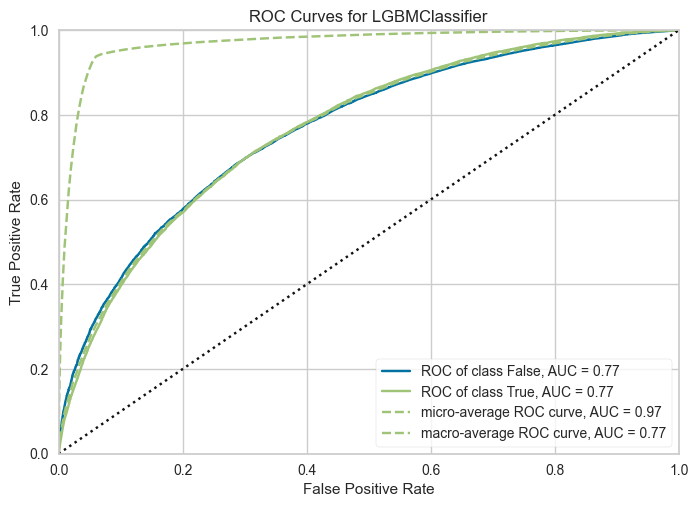

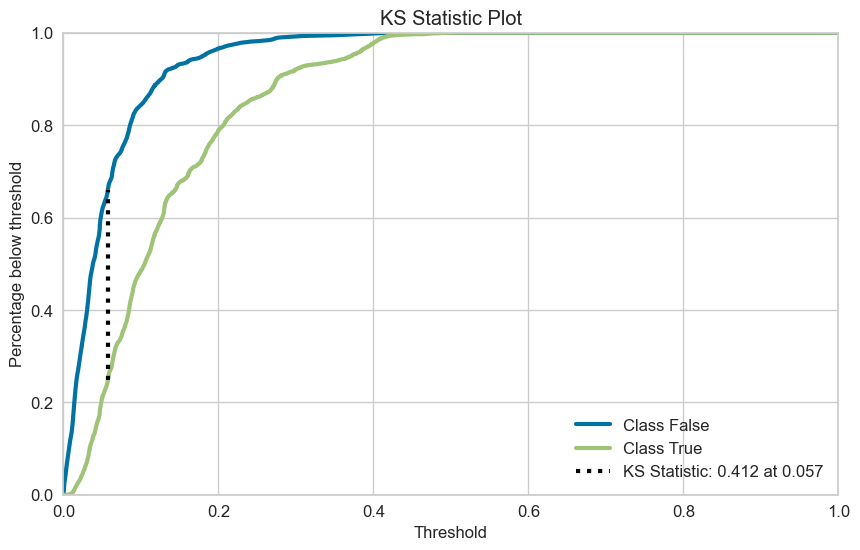

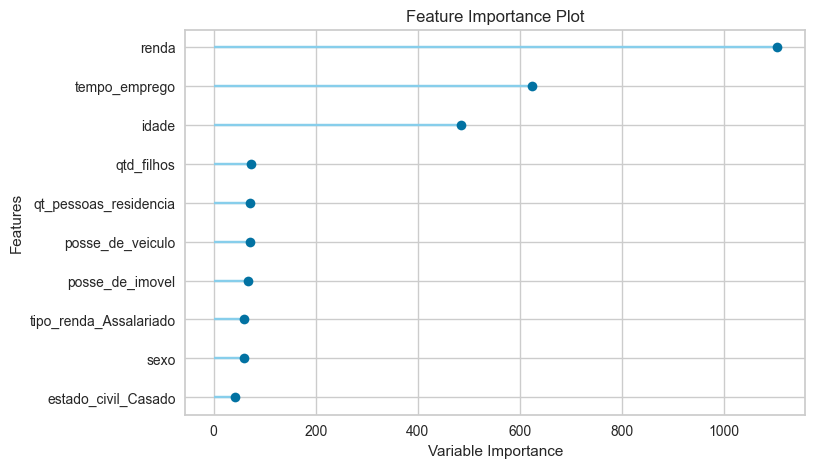

In [50]:
plot_model(modelo_lgbm, plot='auc')
plot_model(modelo_lgbm, plot='ks')
plot_model(modelo_lgbm, plot='feature')

In [51]:
# ============================================================
# IMPORTANDO FUNÇÃO PARA SALVAR MODELO
# ============================================================

# Importando explicitamente a função save_model
# Isso garante que ela esteja disponível no ambiente

from pycaret.classification import save_model

In [52]:
# ============================================================
# SALVANDO O MODELO TREINADO - LIGHTGBM (PYCARET)
# ============================================================

# Salvando o modelo treinado juntamente com todo o pipeline
# O arquivo será salvo com extensão .pkl automaticamente

save_model(modelo_lgbm, 'modelo_lightgbm_credit_scoring')

print("Modelo salvo com sucesso.")

Transformation Pipeline and Model Successfully Saved
Modelo salvo com sucesso.


In [53]:
# ============================================================
# PIPELINE FINAL + TREINAMENTO DO MODELO
# ============================================================

import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Criando pipeline completo com preprocessamento + modelo
pipeline_modelo = Pipeline([
    ('preprocessamento', preprocessador),  # ColumnTransformer criado anteriormente
    ('modelo', LogisticRegression(max_iter=1000))
])

# Treinando pipeline completo
pipeline_modelo.fit(X_dev, y_dev)

print("Modelo treinado com sucesso.")

Modelo treinado com sucesso.


In [54]:
# ============================================================
# SALVANDO MODELO FINAL PARA STREAMLIT
# ============================================================

# Salvando pipeline completo (preprocessamento + modelo)
joblib.dump(pipeline_modelo, 'model_final.pkl')

print("Arquivo model_final.pkl salvo com sucesso.")

Arquivo model_final.pkl salvo com sucesso.


In [55]:
# ============================================================
# TREINAMENTO FINAL - LIGHTGBM MANUAL
# ============================================================

import joblib
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# Criando modelo LightGBM com parâmetros estáveis
modelo_lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Criando pipeline completo (preprocessamento + modelo)
pipeline_modelo = Pipeline([
    ('preprocessamento', preprocessador),  # ColumnTransformer criado anteriormente
    ('modelo', modelo_lgbm)
])

# Treinando modelo
pipeline_modelo.fit(X_dev, y_dev)

print("Modelo LightGBM treinado com sucesso.")

[LightGBM] [Info] Number of positive: 36643, number of negative: 563357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061072 -> initscore=-2.732691
[LightGBM] [Info] Start training from score -2.732691
Modelo LightGBM treinado com sucesso.


In [56]:
# ============================================================
# SALVANDO MODELO FINAL PARA STREAMLIT
# ============================================================

# Salvando pipeline completo
joblib.dump(pipeline_modelo, 'model_final.pkl')

print("Arquivo model_final.pkl salvo com sucesso.")

Arquivo model_final.pkl salvo com sucesso.


In [57]:
# ============================================================
# VALIDAÇÃO DA BASE ESCORADA
# ============================================================

import pandas as pd

df_escorada = pd.read_csv("base_escorada.csv")

print("Dimensão da base:", df_escorada.shape)

print("\nColunas:")
print(df_escorada.columns)

print("\nResumo estatístico do score:")
print(df_escorada['score_probabilidade'].describe())

Dimensão da base: (750000, 16)

Colunas:
Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'score_probabilidade'],
      dtype='object')

Resumo estatístico do score:
count    750000.000000
mean          0.000508
std           0.000742
min           0.000126
25%           0.000265
50%           0.000319
75%           0.000451
max           0.035954
Name: score_probabilidade, dtype: float64


In [58]:
#Classificando o risco

df_escorada['classe_risco'] = df_escorada['score_probabilidade'].apply(
    lambda x: "Alto Risco" if x >= 0.5 else "Baixo Risco"
)

In [59]:
df_escorada.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,score_probabilidade,classe_risco
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,0.000245,Baixo Risco
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,0.000447,Baixo Risco
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,0.000840,Baixo Risco
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,0.000343,Baixo Risco
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,0.000335,Baixo Risco


In [60]:
df_escorada['classe_risco'].value_counts(normalize=True)

classe_risco
Baixo Risco    1.0
Name: proportion, dtype: float64

In [61]:
# ============================================================
# ANALISANDO DISTRIBUIÇÃO DAS PROBABILIDADES
# ============================================================

print(df_escorada['score_probabilidade'].describe())

print("\nMaior probabilidade:", df_escorada['score_probabilidade'].max())
print("Menor probabilidade:", df_escorada['score_probabilidade'].min())

count    750000.000000
mean          0.000508
std           0.000742
min           0.000126
25%           0.000265
50%           0.000319
75%           0.000451
max           0.035954
Name: score_probabilidade, dtype: float64

Maior probabilidade: 0.0359538557025895
Menor probabilidade: 0.0001260353761562


In [62]:
#MELHORANDO O MODELO PARA CLASSIFICAR MAIS CLIENTES COM ALTO RISCO
# ============================================================
# CLASSIFICAÇÃO POR PERCENTIL (TOP 5% MAIOR RISCO)
# ============================================================

# Calculando ponto de corte no percentil 95
cutoff = df_escorada['score_probabilidade'].quantile(0.95)

print("Cutoff (P95):", cutoff)

# Classificando
df_escorada['classe_risco'] = df_escorada['score_probabilidade'].apply(
    lambda x: "Alto Risco" if x >= cutoff else "Baixo Risco"
)

# Verificando proporção
df_escorada['classe_risco'].value_counts(normalize=True)

Cutoff (P95): 0.0011178815925196


classe_risco
Baixo Risco    0.949679
Alto Risco     0.050321
Name: proportion, dtype: float64

In [63]:
# ============================================================
# ANÁLISE MÉDIA DE SCORE POR CLASSE DE RISCO
# ============================================================

print("Score médio - Alto Risco:")
print(df_escorada[df_escorada['classe_risco'] == 'Alto Risco']['score_probabilidade'].mean())

print("\nScore médio - Baixo Risco:")
print(df_escorada[df_escorada['classe_risco'] == 'Baixo Risco']['score_probabilidade'].mean())

Score médio - Alto Risco:
0.002881874764628089

Score médio - Baixo Risco:
0.0003825077289874459


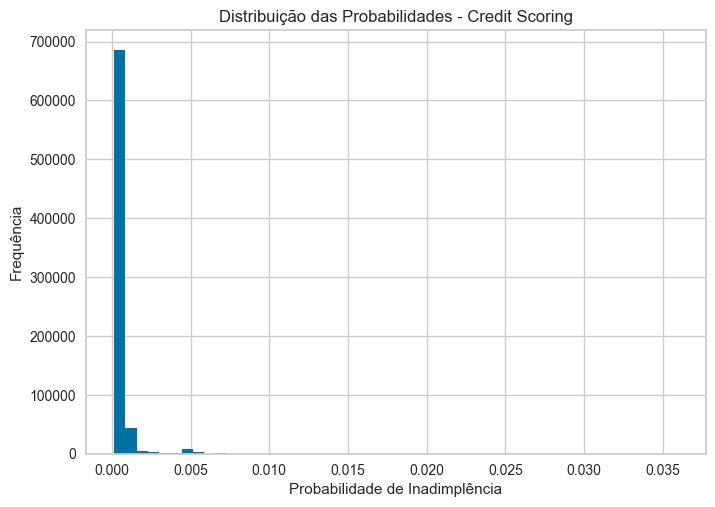

In [64]:
# ============================================================
# DISTRIBUIÇÃO DAS PROBABILIDADES ESTIMADAS
# ============================================================

import matplotlib.pyplot as plt

plt.hist(df_escorada['score_probabilidade'], bins=50)
plt.title("Distribuição das Probabilidades - Credit Scoring")
plt.xlabel("Probabilidade de Inadimplência")
plt.ylabel("Frequência")
plt.show()

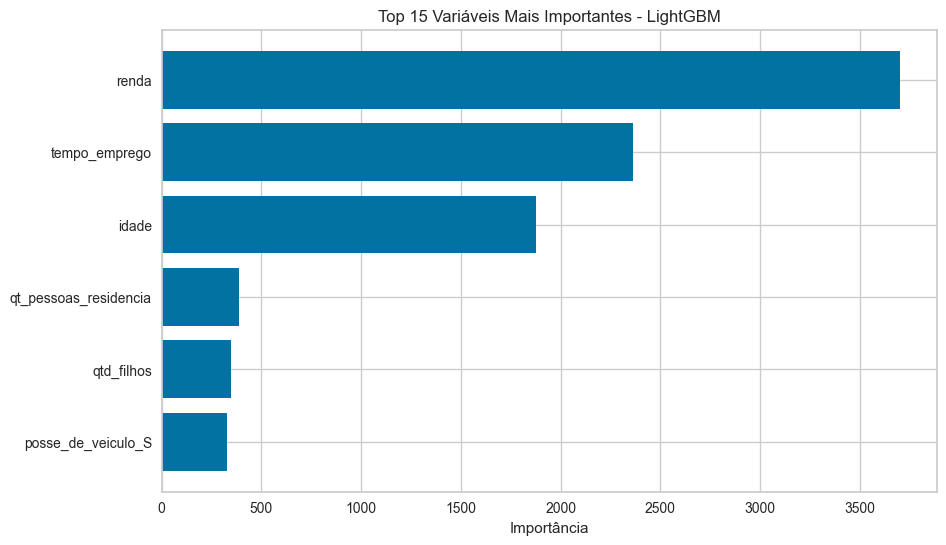

In [68]:
# ============================================================
# EXTRAINDO NOMES REAIS DAS FEATURES DO COLUMNTRANSFORMER
# ============================================================

import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Carregando pipeline salvo
pipeline_modelo = joblib.load("model_final.pkl")

# Extraindo preprocessador e modelo
preprocessador = pipeline_modelo.named_steps['preprocessamento']
modelo = pipeline_modelo.named_steps['modelo']

# ------------------------------------------------------------
# EXTRAINDO NOMES DAS FEATURES NUMÉRICAS
# ------------------------------------------------------------

nomes_features = []

for nome, transformador, colunas in preprocessador.transformers_:
    
    # Se for pipeline numérico (winsor + scaler)
    if nome == 'num':
        nomes_features.extend(colunas)
    
    # Se for categórico (onehotencoder)
    elif nome == 'dummy':
        encoder = transformador.named_steps['onehot']
        nomes_cat = encoder.get_feature_names_out(colunas)
        nomes_features.extend(nomes_cat)

# ------------------------------------------------------------
# CRIANDO DATAFRAME DE IMPORTÂNCIA
# ------------------------------------------------------------

importancias = pd.DataFrame({
    'variavel': nomes_features,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False)

# ------------------------------------------------------------
# PLOTANDO TOP 15
# ------------------------------------------------------------

plt.figure(figsize=(10,6))
plt.barh(importancias['variavel'][:15], importancias['importancia'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Variáveis Mais Importantes - LightGBM")
plt.xlabel("Importância")
plt.show()

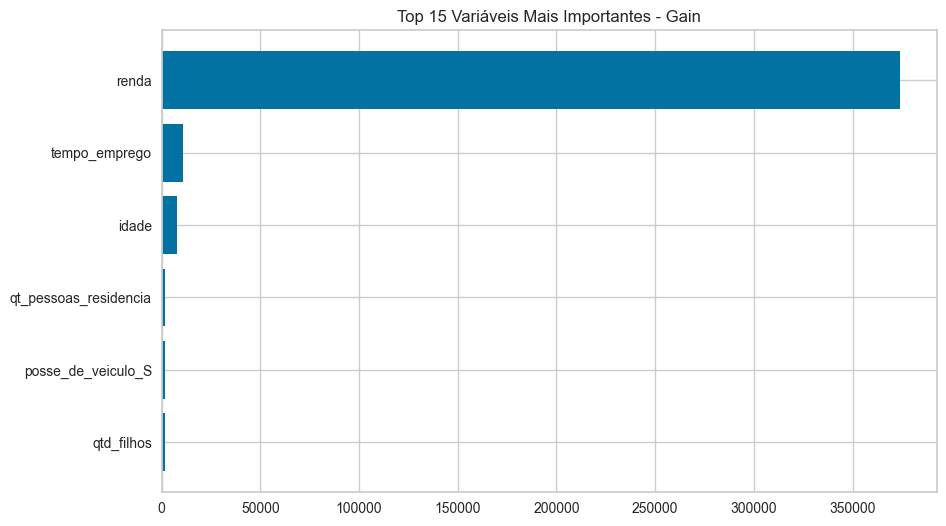

In [70]:
# ============================================================
# FEATURE IMPORTANCE POR GANHO (GAIN)
# ============================================================

importancias_gain = modelo.booster_.feature_importance(importance_type='gain')

importancias = pd.DataFrame({
    'variavel': nomes_features,
    'importancia_gain': importancias_gain
}).sort_values(by='importancia_gain', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importancias['variavel'][:15], importancias['importancia_gain'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Variáveis Mais Importantes - Gain")
plt.show()

In [74]:
# ============================================================
# CURVA LIFT - VERSÃO CORRIGIDA
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ordenando base por score (maior risco primeiro)
df_lift = df_escorada.sort_values(by='score_probabilidade', ascending=False).copy()

# Criando decis (10 grupos iguais em quantidade)
df_lift['decil'] = pd.qcut(df_lift.index, 10, labels=False)

In [75]:
# Taxa média geral de inadimplência
taxa_media = df_lift['mau'].mean()

# Criando tabela resumo
lift_table = df_lift.groupby('decil')['mau'].agg(['count', 'sum'])

lift_table['taxa_inadimplencia'] = lift_table['sum'] / lift_table['count']

# Calculando Lift corretamente
lift_table['lift'] = lift_table['taxa_inadimplencia'] / taxa_media

# Ordenando do maior risco para o menor
lift_table = lift_table.sort_index()

lift_table

,count,sum,taxa_inadimplencia,lift
decil,,,,
0,75000,8519,0.113587,1.452688
1,75000,6150,0.082000,1.048719
2,75000,3580,0.047733,0.610474
3,75000,2447,0.032627,0.417271
4,75000,2101,0.028013,0.358270
5,75000,2639,0.035187,0.450011
6,75000,4456,0.059413,0.759852
7,75000,6751,0.090013,1.151203
8,75000,9848,0.131307,1.679314


In [76]:
print(lift_table.columns)

Index(['count', 'sum', 'taxa_inadimplencia', 'lift'], dtype='object')


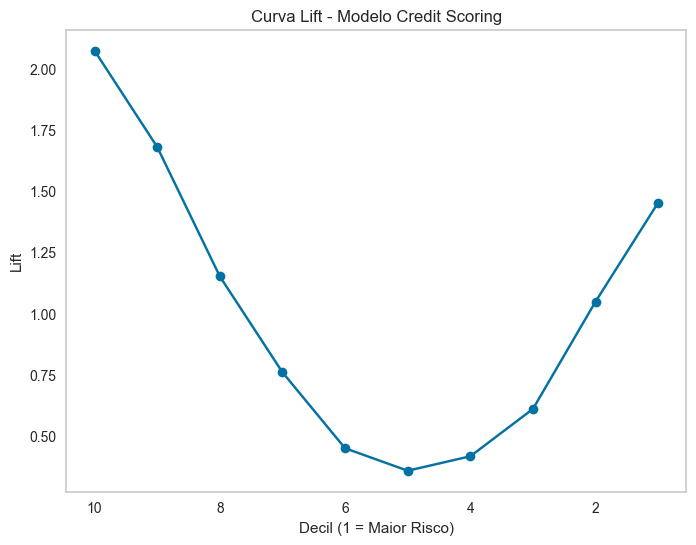

In [77]:
plt.figure(figsize=(8,6))
plt.plot(lift_table.index + 1, lift_table['lift'], marker='o')
plt.title("Curva Lift - Modelo Credit Scoring")
plt.xlabel("Decil (1 = Maior Risco)")
plt.ylabel("Lift")
plt.gca().invert_xaxis()
plt.grid()
plt.show()